<a href="https://colab.research.google.com/github/DAIVIKAD/Machine-Learning-AI-programs/blob/main/grog%20api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Accuracy: 0.75


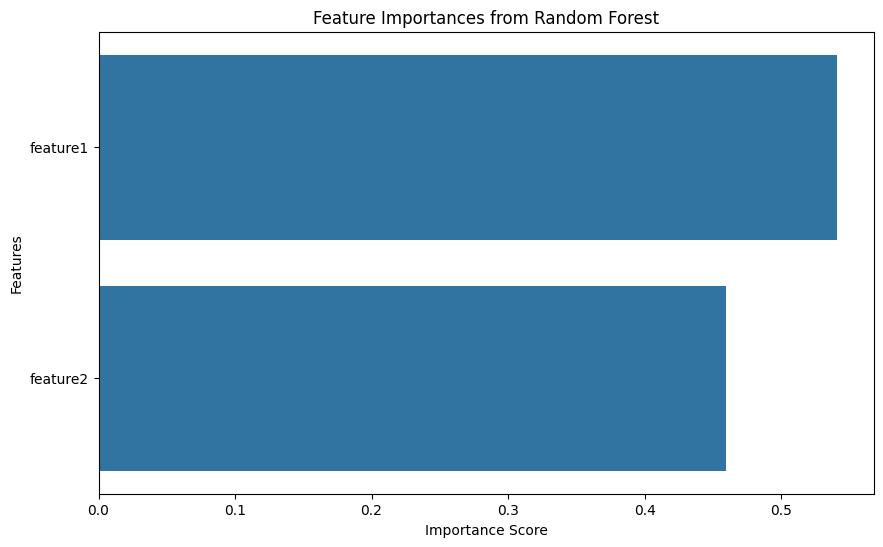

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame named 'df' with features and a target variable
# Replace with your actual data loading and preprocessing steps

# Example: Create dummy data
np.random.seed(42)
data = {
    'feature1': np.random.rand(100),
    'feature2': np.random.rand(100),
    'target': np.random.randint(0, 2, 100)
}
df = pd.DataFrame(data)

# Separate features (X) and target (y)
X = df[['feature1', 'feature2']]
y = df['target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Visualize feature importances using seaborn
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title("Feature Importances from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

In [ ]:
# Colab cell 1 — enter API key securely
from getpass import getpass
api_key = getpass("Enter your GROQ API key (hidden): ")
BASE = "https://api.groq.com/openai/v1"   # Groq OpenAI-compatible base


Enter your GROQ API key (hidden): ··········


In [ ]:
# Colab cell 2 — helper functions: list models and pretty-print
import requests, json, time

headers = {
    "Authorization": f"Bearer {api_key}",
    "Content-Type": "application/json",
}

def list_models():
    try:
        resp = requests.get(f"{BASE}/models", headers=headers, timeout=20)
    except requests.RequestException as e:
        print("Network error while listing models:", e)
        return None, None

    print("Status:", resp.status_code)
    try:
        data = resp.json()
    except Exception:
        print("Non-JSON response while listing models:")
        print(resp.text[:1000])
        return resp.status_code, None

    # Common shapes: {"data":[{...}, ...]} or {"models":[...]} or list
    models = None
    if isinstance(data, dict):
        if "data" in data and isinstance(data["data"], list):
            models = data["data"]
        elif "models" in data and isinstance(data["models"], list):
            models = data["models"]
        else:
            # Maybe a direct mapping of id->info
            # Try to coerce dictionary values to a list of objects that include an 'id' key
            guessed = []
            for k, v in data.items():
                if isinstance(v, dict) and ("id" in v or "model" in v or "name" in v):
                    guessed.append(v)
            if guessed:
                models = guessed
    elif isinstance(data, list):
        models = data

    # Normalize to list of model ids
    model_ids = []
    if models:
        for m in models:
            if isinstance(m, str):
                model_ids.append(m)
            elif isinstance(m, dict):
                mid = m.get("id") or m.get("model") or m.get("name")
                if mid:
                    model_ids.append(mid)
    return resp.status_code, model_ids

# quick test list
status, model_ids = list_models()
if model_ids is None:
    print("Failed to obtain model list. See output above.")
else:
    print(f"Found {len(model_ids)} models (showing up to 50):")
    for i, m in enumerate(model_ids[:50], start=1):
        print(f"{i}. {m}")


Status: 200
Found 20 models (showing up to 50):
1. llama-3.1-8b-instant
2. allam-2-7b
3. llama-3.3-70b-versatile
4. groq/compound-mini
5. groq/compound
6. openai/gpt-oss-20b
7. meta-llama/llama-4-scout-17b-16e-instruct
8. playai-tts
9. moonshotai/kimi-k2-instruct
10. openai/gpt-oss-safeguard-20b
11. meta-llama/llama-prompt-guard-2-86m
12. openai/gpt-oss-120b
13. meta-llama/llama-guard-4-12b
14. whisper-large-v3-turbo
15. meta-llama/llama-4-maverick-17b-128e-instruct
16. playai-tts-arabic
17. qwen/qwen3-32b
18. whisper-large-v3
19. meta-llama/llama-prompt-guard-2-22m
20. moonshotai/kimi-k2-instruct-0905


In [ ]:
# Colab cell 3 — attempt small chat using available models (tries until one succeeds)
import requests, json

def try_chat_with_model(model_id):
    payload = {
        "model": model_id,
        "messages": [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": "Say hello in one short sentence."}
        ],
        "max_tokens": 32
    }
    try:
        resp = requests.post(f"{BASE}/chat/completions", headers=headers, json=payload, timeout=20)
    except requests.RequestException as e:
        return {"ok": False, "error": f"Network error: {e}"}

    # Try to parse JSON and return
    try:
        data = resp.json()
    except Exception:
        return {"ok": False, "status": resp.status_code, "error": "Non-JSON response", "text": resp.text[:1000]}

    if resp.status_code == 200:
        # success
        return {"ok": True, "status": 200, "data": data}
    else:
        # return structured error if present
        err = data.get("error") if isinstance(data, dict) else None
        return {"ok": False, "status": resp.status_code, "error": err or data}

# Main loop: go through the discovered models and try chat
status, model_ids = list_models()
if not model_ids:
    print("No models available to try (or failed to parse model list). Aborting.")
else:
    tried = 0
    success = False
    # limit attempts to avoid long loops
    for model in model_ids[:15]:
        tried += 1
        print(f"\nTrying model #{tried}: {model} ...")
        r = try_chat_with_model(model)
        if r["ok"]:
            print("✅ Chat worked with model:", model)
            print("Response (pretty):")
            print(json.dumps(r["data"], indent=2)[:4000])
            # attempt to print assistant text if present
            try:
                choice = r["data"]["choices"][0]
                assistant_msg = choice.get("message", {}).get("content") or choice.get("text")
                if assistant_msg:
                    print("\nAssistant text:\n", assistant_msg)
            except Exception:
                pass
            success = True
            break
        else:
            st = r.get("status")
            err = r.get("error")
            # known failure patterns: 404 model not found, 401/403 auth, 400 bad request (maybe model doesn't support chat)
            if isinstance(err, dict):
                err_msg = err.get("message") or str(err)
            else:
                err_msg = str(err)
            print(f" failed (status={st}) -> {err_msg}")

    if not success:
        print("\nNo model accepted a /chat/completions request from the first candidates.")
        print("Next steps you can try:")
        print(" - Re-run the 'list_models()' cell to confirm which models the API returned.")
        print(" - If the models list is empty or contains unknown names, contact Groq support or check your account permissions.")
        print(" - If models exist but they fail chat, we will attempt the older /completions route for text-based models next.")


Status: 200

Trying model #1: playai-tts ...
 failed (status=400) -> The model `playai-tts` requires terms acceptance. Please have the org admin accept the terms at https://console.groq.com/playground?model=playai-tts

Trying model #2: moonshotai/kimi-k2-instruct ...
✅ Chat worked with model: moonshotai/kimi-k2-instruct
Response (pretty):
{
  "id": "chatcmpl-457b6272-ec66-4527-99c5-efb5022747b3",
  "object": "chat.completion",
  "created": 1762847026,
  "model": "moonshotai/kimi-k2-instruct",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "Hello there!"
      },
      "logprobs": null,
      "finish_reason": "stop"
    }
  ],
  "usage": {
    "queue_time": 0.073877022,
    "prompt_tokens": 24,
    "prompt_time": 0.018265846,
    "completion_tokens": 4,
    "completion_time": 0.012688741,
    "total_tokens": 28,
    "total_time": 0.030954587
  },
  "usage_breakdown": null,
  "system_fingerprint": "fp_3312304636",
  "x_groq": {
 

In [ ]:
# ✅ Groq-supported chat completion test (fixed model name)

payload = {
    "model": "mixtral-8x7b",   # ✅ Groq-supported model
    "messages": [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Say hello in one short sentence."}
    ],
    "max_tokens": 32
}

resp = requests.post(f"{BASE}/chat/completions", headers=headers, json=payload, timeout=20)
print("Status:", resp.status_code)

try:
    data = resp.json()
    print(json.dumps(data, indent=2))
    if "choices" in data:
        print("\nResponse text:", data["choices"][0]["message"]["content"])
except Exception:
    print(resp.text)


Status: 404
{
  "error": {
    "message": "The model `mixtral-8x7b` does not exist or you do not have access to it.",
    "type": "invalid_request_error",
    "code": "model_not_found"
  }
}


In [ ]:
# Colab cell 4 — fallback: try simple text completions (/completions) for models that may not support chat
# This will try the same models (or a short list) with the /completions endpoint.
import json

def try_completion_with_model(model_id):
    payload = {
        "model": model_id,
        "prompt": "Say hello in one short sentence.",
        "max_tokens": 32
    }
    try:
        resp = requests.post(f"{BASE}/completions", headers=headers, json=payload, timeout=20)
    except requests.RequestException as e:
        return {"ok": False, "error": f"Network error: {e}"}
    try:
        data = resp.json()
    except Exception:
        return {"ok": False, "status": resp.status_code, "error": "Non-JSON response", "text": resp.text[:1000]}

    if resp.status_code == 200:
        return {"ok": True, "status": 200, "data": data}
    else:
        return {"ok": False, "status": resp.status_code, "error": data.get("error") if isinstance(data, dict) else data}

# Run fallback attempts
status, model_ids = list_models()
if not model_ids:
    print("No models to try for fallback completions.")
else:
    for model in model_ids[:10]:
        print(f"\nTrying /completions with model: {model}")
        r = try_completion_with_model(model)
        if r["ok"]:
            print("✅ /completions worked with model:", model)
            print(json.dumps(r["data"], indent=2)[:4000])
            try:
                txt = r["data"]["choices"][0].get("text")
                if txt:
                    print("\nCompletion text:\n", txt)
            except Exception:
                pass
            break
        else:
            print(" failed:", r.get("status"), r.get("error"))
    else:
        print("\nFallback attempts did not succeed for first 10 models.")
        print("If you're still getting model_not_found (404) for every model, it's likely those model IDs are not accessible to your account even though the models endpoint returned them — contact Groq support or check your account plan/permissions.")


Status: 200

Trying /completions with model: allam-2-7b
 failed: 404 {'message': 'Unknown request URL: POST /openai/v1/completions. Please check the URL for typos, or see the docs at https://console.groq.com/docs/', 'type': 'invalid_request_error', 'code': 'unknown_url'}

Trying /completions with model: groq/compound
 failed: 404 {'message': 'Unknown request URL: POST /openai/v1/completions. Please check the URL for typos, or see the docs at https://console.groq.com/docs/', 'type': 'invalid_request_error', 'code': 'unknown_url'}

Trying /completions with model: openai/gpt-oss-120b
 failed: 404 {'message': 'Unknown request URL: POST /openai/v1/completions. Please check the URL for typos, or see the docs at https://console.groq.com/docs/', 'type': 'invalid_request_error', 'code': 'unknown_url'}

Trying /completions with model: meta-llama/llama-4-scout-17b-16e-instruct
 failed: 404 {'message': 'Unknown request URL: POST /openai/v1/completions. Please check the URL for typos, or see the do

In [ ]:
def test_groq_chat(model_name, prompt="Say hello from this model!"):
    payload = {
        "model": model_name,
        "messages": [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ],
        "max_tokens": 64
    }
    r = requests.post(f"{BASE}/chat/completions", headers=headers, json=payload, timeout=20)
    print(f"\nModel: {model_name}")
    print("Status:", r.status_code)
    try:
        data = r.json()
        if r.status_code == 200:
            msg = data["choices"][0]["message"]["content"]
            print("✅ Output:", msg)
        else:
            print("❌ Error:", data)
    except Exception:
        print("Non-JSON response:", r.text[:1000])

# 🔹 Try a few text models
for model in ["openai/gpt-oss-20b", "llama-3.1-8b-instant", "llama-3.3-70b-versatile"]:
    test_groq_chat(model)



Model: openai/gpt-oss-20b
Status: 200
✅ Output: 

Model: llama-3.1-8b-instant
Status: 200
✅ Output: Hello. Welcome to our conversation. Is there something I can help you with or would you like to discuss a particular topic?

Model: llama-3.3-70b-versatile
Status: 200
✅ Output: Hello from this model. It's nice to meet you. Is there anything I can help you with or would you like to chat?


In [ ]:
# Colab cell 1 — secure API key input and basic setup
from getpass import getpass
import requests, textwrap, json, urllib.parse, time

print("Groq-powered Drug Lookup + Summarizer")
API_KEY = getpass("Enter your GROQ API key (hidden): ").strip()
BASE = "https://api.groq.com/openai/v1"
headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Content-Type": "application/json",
}


Groq-powered Drug Lookup + Summarizer
Enter your GROQ API key (hidden): ··········


In [ ]:
# Colab cell 2 — helper: list available models (so you can choose)
def list_models():
    try:
        r = requests.get(f"{BASE}/models", headers=headers, timeout=15)
    except Exception as e:
        print("Network error listing models:", e)
        return None
    if r.status_code == 200:
        try:
            data = r.json()
        except Exception:
            print("Non-JSON response when listing models:", r.text[:500])
            return None
        # normalize
        models = []
        if isinstance(data, dict):
            if "data" in data and isinstance(data["data"], list):
                models = [m.get("id") or m.get("model") or m.get("name") for m in data["data"]]
            elif "models" in data and isinstance(data["models"], list):
                models = [m if isinstance(m, str) else (m.get("id") or m.get("name")) for m in data["models"]]
            else:
                # fallback: any keys that look like model ids
                for k,v in data.items():
                    if isinstance(v, dict) and ("id" in v or "name" in v):
                        models.append(v.get("id") or v.get("name"))
        elif isinstance(data, list):
            models = [m if isinstance(m, str) else (m.get("id") or m.get("name")) for m in data]
        # filter None
        models = [m for m in models if m]
        return models
    else:
        print(f"List models returned {r.status_code}: {r.text[:500]}")
        return None

models = list_models()
if not models:
    print("Could not fetch model list. You can still proceed by entering a model name manually (if you know one).")
else:
    print(f"Found {len(models)} models. Example models:\n", "\n".join(models[:30]))
    # Prefer a chat-like model automatically (common indicators)
    preferred = None
    for m in models:
        low = m.lower()
        if any(k in low for k in ["chat", "gpt", "llama", "qwen", "gpt-oss", "llama-3", "openai/gpt-oss"]):
            preferred = m
            break
    if preferred:
        print("\nAuto-selected model:", preferred)
    else:
        print("\nNo obvious chat-capable model auto-selected — you'll be prompted to choose one.")


Found 20 models. Example models:
 playai-tts
openai/gpt-oss-20b
whisper-large-v3
openai/gpt-oss-safeguard-20b
meta-llama/llama-prompt-guard-2-86m
playai-tts-arabic
meta-llama/llama-4-maverick-17b-128e-instruct
llama-3.3-70b-versatile
qwen/qwen3-32b
meta-llama/llama-4-scout-17b-16e-instruct
moonshotai/kimi-k2-instruct-0905
groq/compound-mini
llama-3.1-8b-instant
whisper-large-v3-turbo
allam-2-7b
groq/compound
meta-llama/llama-guard-4-12b
openai/gpt-oss-120b
moonshotai/kimi-k2-instruct
meta-llama/llama-prompt-guard-2-22m

Auto-selected model: openai/gpt-oss-20b


In [ ]:
# Colab cell 3 — data source fetchers (openFDA, RxNav, Wikipedia)
BASE_OPENFDA = "https://api.fda.gov/drug/label.json"
RXNAV_APPROX = "https://rxnav.nlm.nih.gov/REST/approximateTerm.json"
WIKI_API = "https://en.wikipedia.org/w/api.php"

def fetch_openfda(name):
    """Try to fetch a label from openFDA (US labels)."""
    try:
        q = urllib.parse.quote(f'brand_name:"{name}" OR generic_name:"{name}"')
        r = requests.get(f"{BASE_OPENFDA}?search={q}&limit=1", timeout=12)
    except Exception as e:
        return None, f"error:{e}"
    if r.status_code != 200:
        return None, f"status_{r.status_code}"
    try:
        d = r.json()
        res = d.get("results")
        if res:
            # join relevant fields into a short text
            txt = []
            for k in ("indications_and_usage","dosage_and_administration","purpose","warnings","adverse_reactions"):
                if res[0].get(k):
                    v = res[0].get(k)
                    if isinstance(v, list):
                        txt.append("\n\n".join(v))
                    else:
                        txt.append(str(v))
            return {"source":"openfda","raw":res[0],"text":"\n\n".join(txt)}, None
        return None, "no_results"
    except Exception as e:
        return None, f"json_err:{e}"

def fetch_rxnav(name):
    """Try RxNav approximateTerm for RxNorm concept (US-centered)."""
    try:
        r = requests.get(RXNAV_APPROX, params={"term":name,"maxEntries":3}, timeout=10)
    except Exception as e:
        return None, f"error:{e}"
    if r.status_code != 200:
        return None, f"status_{r.status_code}"
    try:
        data = r.json()
    except Exception as e:
        return None, f"json_err:{e}"
    cands = data.get("approximateGroup", {}).get("candidate", [])
    if not cands:
        return None, "no_candidates"
    top = cands[0]
    # fetch properties
    rxcui = top.get("rxcui")
    props = {}
    try:
        pr = requests.get(f"https://rxnav.nlm.nih.gov/REST/rxcui/{rxcui}/properties.json", timeout=8)
        if pr.status_code == 200:
            props = pr.json().get("properties",{})
    except:
        pass
    text = f"RxNav candidate: {top.get('candidate')} (rxcui:{rxcui})\nProperties: {props}"
    return {"source":"rxnav","raw":top,"text":text}, None

def fetch_wikipedia(name):
    """Search Wikipedia and fetch first paragraphs and 'Dosage' section if present."""
    try:
        s = requests.get(WIKI_API, params={"action":"query","list":"search","srsearch":name,"format":"json","srlimit":3}, timeout=10)
        s.raise_for_status()
        js = s.json()
        hits = js.get("query",{}).get("search",[])
        if not hits:
            return None, "no_hits"
        page = hits[0]
        title = page.get("title")
        # fetch page content (extract)
        ex = requests.get(WIKI_API, params={"action":"query","prop":"extracts|sections","titles":title,"format":"json","explaintext":1,"exintro":1}, timeout=10)
        ex.raise_for_status()
        exj = ex.json()
        pages = exj.get("query",{}).get("pages",{})
        pageid = next(iter(pages))
        extract = pages[pageid].get("extract","")
        # try to fetch full html to parse specific section "Dosage", "Administration", or "Usage"
        full = requests.get(WIKI_API, params={"action":"parse","page":title,"format":"json","prop":"text"}, timeout=10)
        dosage_text = ""
        if full.status_code == 200:
            fj = full.json()
            html = fj.get("parse",{}).get("text",{}).get("*","")
            from bs4 import BeautifulSoup
            soup = BeautifulSoup(html, "html.parser")
            # search for headings like dosage/administration
            for h in soup.find_all(["h2","h3"]):
                heading = h.get_text().strip().lower()
                if "dosage" in heading or "administration" in heading or "usage" in heading:
                    # get following sibling paragraphs
                    ptexts = []
                    sibling = h.find_next_sibling()
                    while sibling and sibling.name in ["p","ul","ol"]:
                        ptexts.append(sibling.get_text().strip())
                        sibling = sibling.find_next_sibling()
                    dosage_text = "\n\n".join(ptexts)
                    break
        combined = (f"Wikipedia intro for {title}:\n\n{extract}\n\nDosage/Administration section (if found):\n\n{dosage_text}").strip()
        return {"source":"wikipedia","title":title,"text":combined}, None
    except Exception as e:
        return None, f"error:{e}"


In [ ]:
# Colab cell 4 — Groq chat call helper (constructs prompt and asks model to summarize dosage/when to take)
def call_groq_chat(model_id, system_prompt, user_prompt, max_tokens=450):
    payload = {
        "model": model_id,
        "messages": [
            {"role":"system","content": system_prompt},
            {"role":"user","content": user_prompt}
        ],
        "max_tokens": max_tokens
    }
    try:
        r = requests.post(f"{BASE}/chat/completions", headers=headers, json=payload, timeout=30)
    except Exception as e:
        return None, f"network_error:{e}"
    if r.status_code == 200:
        try:
            return r.json(), None
        except Exception as e:
            return None, f"json_err:{e}"
    else:
        # surface returned JSON error if present
        try:
            return None, r.json()
        except:
            return None, {"status": r.status_code, "text": r.text[:1000]}

# summarizer orchestration
def summarize_drug_with_groq(model_id, drug_name, sources):
    """
    sources: list of dicts like {"source":"openfda","text": "..."} (text may be empty)
    """
    # build the prompt
    system_prompt = (
        "You are a careful, safety-conscious medical information summarizer. "
        "Given raw source excerpts from public drug information (FDA labels, RxNorm, Wikipedia), "
        "produce a concise, plain-language summary for a layperson that includes:\n"
        "1) Drug name(s) and a short description (one sentence).\n"
        "2) Typical uses/indications.\n"
        "3) Typical dosage ranges or common dosing instructions and WHEN to take it (e.g., with food, at night) if present in the sources; label exact phrasing if uncertain.\n"
        "4) Important warnings or contraindications (brief).\n"
        "5) A clear safety disclaimer reminding the user to follow their prescription and consult a healthcare professional.\n\n"
        "If the sources conflict or do not include dosing information, explicitly say so and recommend consulting a clinician or pharmacist. "
        "When possible, cite which source provided the dosing (e.g., [openfda], [rxnav], [wikipedia]). "
        "Keep the answer under 400 words but include key dosage numbers if available.\n"
        "Do NOT invent dosing; if dosing is missing, say it is not present in the sources.\n"
    )

    # build a single user prompt concatenating source snippets (truncate if too long)
    parts = [f"Drug query: {drug_name}\n"]
    for s in sources:
        header = f"--- SOURCE: {s.get('source','unknown')} ---\n"
        text = s.get("text","").strip()
        # limit each source text to e.g. 2500 chars
        if text:
            if len(text) > 2500:
                text = text[:2500] + "\n...[truncated]"
            parts.append(header + text + "\n")
    user_prompt = "\n\n".join(parts)
    # final instruction to model to produce the requested summary
    user_prompt += "\n\nPlease produce the concise summary described above."

    # call Groq
    resp, err = call_groq_chat(model_id, system_prompt, user_prompt)
    if err:
        return None, err
    # parse assistant message
    try:
        msg = resp["choices"][0]["message"]["content"]
        return msg, None
    except Exception as e:
        return None, f"parse_err:{e}"


In [ ]:
# Colab cell 5 — main interactive loop: accepts a tablet/drug name and prints Groq summary
# If you have a preferred model (from earlier list), set it here. Otherwise you'll be prompted.
preferred_model = None
try:
    # If list_models succeeded earlier, use the selected 'preferred' if present
    if 'preferred' in globals() and preferred:
        preferred_model = preferred
except:
    preferred_model = None

if not preferred_model:
    if models:
        # pick the first model (safe fallback) — user can override below
        preferred_model = models[0]
print("Using model:", preferred_model)
print("\nNow enter medication names. Type 'quit' to exit.\n")

while True:
    name = input("Enter tablet/medication name (brand or generic) — or 'quit' to exit: ").strip()
    if not name:
        continue
    if name.lower() in ("quit","exit"):
        print("Goodbye.")
        break

    # gather sources
    sources = []
    of, e = fetch_openfda(name)
    if of:
        sources.append(of)
    else:
        #print("openFDA:", e)
        pass
    rx, e2 = fetch_rxnav(name)
    if rx:
        sources.append(rx)
    else:
        #print("rxnav:", e2)
        pass
    wk, e3 = fetch_wikipedia(name)
    if wk:
        sources.append(wk)
    else:
        #print("wikipedia:", e3)
        pass

    if not sources:
        print("No public-source information found (openFDA/RxNav/Wikipedia).")
        print("You can still ask the Groq model for general info, but it will be forced to rely on general knowledge (may be outdated).")
        confirm = input("Do you want me to ask the Groq model anyway for a general summary? (y/N): ").strip().lower()
        if confirm != "y":
            continue
        # create an explicit empty source prompt telling the model no sources were found
        sources = [{"source":"none","text":"No public sources (openFDA, RxNav, Wikipedia) returned results for this name."}]

    # call the model
    print("\nContacting Groq model to summarize... (this will use tokens on your account)\n")
    summary, err = summarize_drug_with_groq(preferred_model, name, sources)
    if err:
        print("Groq call error:", err)
    else:
        print("\n" + "="*60 + "\nGROQ SUMMARY\n" + "="*60 + "\n")
        print(textwrap.fill(summary, width=100))
        print("\n" + "="*60 + "\n")


Using model: openai/gpt-oss-20b

Now enter medication names. Type 'quit' to exit.

Enter tablet/medication name (brand or generic) — or 'quit' to exit: dolo

Contacting Groq model to summarize... (this will use tokens on your account)


GROQ SUMMARY

**Drug name:** No drug matching “dolo” was found in the provided source.  **Summary:**   The
available source (RxNorm) does not contain any information about a drug named “dolo.” Because no
indications, dosing instructions, warnings, or other details were retrieved, a plain‑language
summary cannot be provided.  **Key points**  - No clinical or regulatory data for “dolo” were
available.   - If “dolo” is intended to refer to a different medication (e.g., a brand or generic
name), please check the exact spelling or additional identifiers (e.g., chemical name, brand name,
or CAS number).  **Important reminder**  - Always follow the prescription or guidance from a
licensed healthcare professional.   - If you are looking for information on a spe

In [ ]:
!pip install requests --quiet

